In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# 推荐系统之DeepFM
问题导向：
1. FM部分的数据怎么输入？  
2. Linear、FM和DNN的三部分如何结合？  
3. EMbedding中的权值怎么共享？

## DeepFM网络
<font color = "blue">**思想**</font> ：为了同时学习高阶和低阶的组合特征，Deep FM集成了因子分解机（FM）和深度神经网络（DNN）的体系结构。FM算法负责对一阶特征以及二阶特征（由一阶特征交叉组合得到的）进行特征的提取；DNN算法负责对高阶特征进行特征的提取。  
<font color = "blue">**数据输入说明**</font> ：  
一阶：原始输入特征X  
二阶：Embedding向量两两交叉  
高阶：concat（稠密特征（归一化）, 稀疏特征（Embedding化））  
<font color = "blue">**图示**</font> ：  
![](./imgs/DeepFM.png)  
<font color = "blue">**联合训练**</font> ：  
$$
y = sigmoid(y_{FM} + y_{DNN})
$$  
<font color = "blue">**优点**</font> :  
* 逻辑回归(LR)：更多考虑线性特征，缺少特征交叉性和高阶特征
* DNN：考虑了高阶特征，缺少了对于低阶特征的考虑
* CNN：考虑近邻特征的关系。较单一，适合图片分类
* RNN：考虑更多的是数据时序性，较单一
* FM：考虑更多低阶特征，缺少高阶特征
* Wide&Deep：同时考虑了低阶特征和高阶特征，但是低阶特征需要手动交叉生成，对用户不友好
* DeepFM：兼顾了低阶和高阶特征，且计算过程中不需要用户干预

In [3]:
class BaseModel:
    pass


class DeepFM(BaseModel):
    """Instantiates the DeepFM Network architecture.

    :param linear_feature_columns: An iterable containing all the features used by linear part of the model.
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param use_fm: bool,use FM part or not
    :param dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of DNN
    :param l2_reg_linear: float. L2 regularizer strength applied to linear part
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param init_std: float,to use as the initialize std of embedding vector
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :param task: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss
    :param device: str, ``"cpu"`` or ``"cuda:0"``
    :return: A PyTorch model instance.

    """

    def __init__(self,
                 linear_feature_columns, dnn_feature_columns, use_fm=True,
                 dnn_hidden_units=(256, 128),
                 l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, init_std=0.0001, seed=1024,
                 dnn_dropout=0,
                 dnn_activation='relu', dnn_use_bn=False, task='binary', device='cpu'):

        super(DeepFM, self).__init__(linear_feature_columns, dnn_feature_columns, l2_reg_linear=l2_reg_linear,
                                     l2_reg_embedding=l2_reg_embedding, init_std=init_std, seed=seed, task=task,
                                     device=device)

        self.use_fm = use_fm
        self.use_dnn = len(dnn_feature_columns) > 0 and len(
            dnn_hidden_units) > 0
        if use_fm:
            self.fm = FM()

        if self.use_dnn:
            self.dnn = DNN(self.compute_input_dim(dnn_feature_columns), dnn_hidden_units,
                           activation=dnn_activation, l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, use_bn=dnn_use_bn,
                           init_std=init_std, device=device)
            self.dnn_linear = nn.Linear(
                dnn_hidden_units[-1], 1, bias=False).to(device)

            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.dnn.named_parameters()), l2_reg_dnn)
            self.add_regularization_weight(self.dnn_linear.weight, l2_reg_dnn)
        self.to(device)

    def forward(self, X):

        sparse_embedding_list, dense_value_list = self.input_from_feature_columns(X, self.dnn_feature_columns,

                                                                                  self.embedding_dict)
        # 1.线性层
        logit = self.linear_model(X)

        # 2.FM层
        if self.use_fm and len(sparse_embedding_list) > 0:
            # sparse_embedding_list -->(F, B, 1, 4)
            fm_input = torch.cat(sparse_embedding_list, dim=1)  # （B, F, E）
            logit += self.fm(fm_input)

        # 3.Deep层(concat(稀疏特征(Embedding),稠密特征))
        if self.use_dnn:
            dnn_input = combined_dnn_input(
                sparse_embedding_list, dense_value_list)
            dnn_output = self.dnn(dnn_input)
            dnn_logit = self.dnn_linear(dnn_output)
            logit += dnn_logit

        y_pred = self.out(logit)

        return y_pred

## FM Part(二阶特征)
思想：FM算法的特征交叉不是直接拿原始特征相互交叉计算，而是交叉特征因子分解后的结果，这样更能挖掘出特征深层的信息。
### 源代码
 
模型结构：  
![](./imgs/FM.png)  

In [4]:
class FM(nn.Module):

    """Factorization Machine models pairwise (order-2) feature interactions
     without linear term and bias.
      Input shape
        - 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, 1)``.
      References
        - [Factorization Machines](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)
    """

    def __init__(self):
        super(FM, self).__init__()

    def forward(self, inputs):
        fm_input = inputs  # (B, F, E_K)

        square_of_sum = torch.pow(
            torch.sum(fm_input, dim=1, keepdim=True), 2)  # 　B * 1 * K
        sum_of_square = torch.sum(
            fm_input * fm_input, dim=1, keepdim=True)  # B * 1 * K
        cross_term = square_of_sum - sum_of_square
        cross_term = 0.5 * torch.sum(cross_term, dim=2, keepdim=False)  # B * 1

        return cross_term

In [5]:
# 实例化
fm = FM()
input_ = torch.rand((32, 26, 4))
fm(input_).shape

torch.Size([32, 1])

### 交叉相关计算
交叉项计算公式,计算为onehot为一个特征：  
$$
交叉项：1/2*\sum_{i=1}^{k}((\sum_{i=1}^n{v_{ik}*x_{i}})^2 - \sum_{i=1}^{n}{v_{ik}^2*x_{i}^2})\tag{1}\\ 
$$
$$
inter1 := 1/2*(\sum_{i=1}^n{v_{ik}*x_{i}})^2\tag{2}\\
$$
$$
inter2 := 1/2*(\sum_{i=1}^{n}{v_{ik}^2*x_{i}^2})\tag{3}
$$  

FM原始的方法中只计算不为零的特征向量的隐权重向量向量，因此在特征稀疏的情况下，FM的求解会更加高效，而在DeepFM中交叉项为稀疏特征向量的Embedding向量(concat所有稀疏特征向量的embedding向量)两两交叉，实值为１, 例如：$x_i = 1, Ei.shape＝（1, k）$，因此，最终计算只涉及Embedding向量的计算：  
![](./imgs/cal.png)

In [5]:
# B*F*E (Ｆ:n_filed, E:embed_dims)
input_.shape

torch.Size([32, 26, 4])

In [6]:
# inter1
# B*1*K
inter1 = 0.5*torch.pow(torch.sum(input_, dim=1, keepdim=True), 2)
inter1.size()

torch.Size([32, 1, 4])

In [7]:
# inter2
# B*1*K
inter2 = 0.5*torch.sum(input_*input_, dim=1, keepdim=True)
inter2.size()

torch.Size([32, 1, 4])

In [8]:
# sum of cross
# B*1
torch.sum((inter1 - inter2), dim=2, keepdim=False).size()

torch.Size([32, 1])

## Linear层的探索(一阶特征)
### 线性层
<font color="red">注意</font>：一阶部分针对Embedding的处理

In [9]:
class Linear(nn.Module):
    def __init__(self, feature_columns, feature_index, init_std=0.0001, device='cpu'):
        super(Linear, self).__init__()
        self.feature_index = feature_index
        self.device = device
        self.sparse_feature_columns = list(
            filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []
        self.dense_feature_columns = list(
            filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

        self.varlen_sparse_feature_columns = list(
            filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if len(feature_columns) else []

        self.embedding_dict = create_embedding_matrix(feature_columns, init_std, linear=True, sparse=False,
                                                      device=device)

        #         nn.ModuleDict(
        #             {feat.embedding_name: nn.Embedding(feat.dimension, 1, sparse=True) for feat in
        #              self.sparse_feature_columns}
        #         )
        # .to("cuda:1")
        for tensor in self.embedding_dict.values():
            nn.init.normal_(tensor.weight, mean=0, std=init_std)

        if len(self.dense_feature_columns) > 0:
            self.weight = nn.Parameter(torch.Tensor(sum(fc.dimension for fc in self.dense_feature_columns), 1).to(
                device))
            torch.nn.init.normal_(self.weight, mean=0, std=init_std)

    def forward(self, X, sparse_feat_refine_weight=None):

        sparse_embedding_list = [self.embedding_dict[feat.embedding_name](
            X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]].long()) for
            feat in self.sparse_feature_columns]

        dense_value_list = [X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]] for feat in
                            self.dense_feature_columns]

        varlen_embedding_list = get_varlen_pooling_list(self.embedding_dict, X, self.feature_index,
                                                        self.varlen_sparse_feature_columns, self.device)

        sparse_embedding_list += varlen_embedding_list

        linear_logit = torch.zeros([X.shape[0], 1]).to(
            sparse_embedding_list[0].device)

        if len(sparse_embedding_list) > 0:
            sparse_embedding_cat = torch.cat(sparse_embedding_list, dim=-1)
            if sparse_feat_refine_weight is not None:  # 稀疏特征定义权重
                # w_{x,i}=m_{x,i} * w_i (in IFM and DIFM)
                sparse_embedding_cat = sparse_embedding_cat * \
                    sparse_feat_refine_weight.unsqueeze(1)
            sparse_feat_logit = torch.sum(
                sparse_embedding_cat, dim=-1, keepdim=False)  # 稀疏的Embedding向量简单拼接没有独立权重
            linear_logit += sparse_feat_logit

        if len(dense_value_list) > 0:
            dense_value_logit = torch.cat(
                dense_value_list, dim=-1).matmul(self.weight)  # 稠密特征有独立权重
            linear_logit += dense_value_logit

        return linear_logit

### linear_sparse_logit


In [10]:
# sparse_embedding_list
C = [torch.rand((32, 1, 4)) for i in range(26)]

In [11]:
cat_vector = torch.cat(C, dim=-1)
cat_vector.size()

torch.Size([32, 1, 104])

In [13]:
logit = torch.sum(cat_vector, dim=-1, keepdim=False)
logit.size()

torch.Size([32, 1])

### linear_dense_logit 


In [38]:
# dense_value_list
weight = torch.rand(26, 1)
C = [torch.rand((32, 1)) for i in range(26)]

In [17]:
# 拼接
dense_vector = torch.cat(C, dim=-1)
dense_vector.size()

torch.Size([32, 26])

In [18]:
# 加权求和
torch.matmul(dense_vector, weight).size()

torch.Size([32, 1])

## DeepFM实战练习

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import DeepFM
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings
from matplotlib import rcParams
from torch.utils.tensorboard import SummaryWriter

warnings.filterwarnings("ignore")
config = {
    "font.family": 'Times New Roman',  # 设置字体类型
}

rcParams.update(config)

Embed_dims = 4

### 数据预处理

In [20]:
train_data = pd.read_csv("../PNN模型/data/process/train_set.csv")
val_data = pd.read_csv("../PNN模型/data/process/val_set.csv")
test_data = pd.read_csv("../PNN模型/data/process/test_data.csv")
all_data = pd.concat([train_data, val_data], axis=0)

In [21]:
# 编码信息
feature_names = all_data.columns.values.tolist()
sparse_feats = [c for c in feature_names if c[0] == "C"]
dense_feats = [c for c in feature_names if c[0] == "I"]

In [22]:
# LabelEncoder
lb = LabelEncoder()
for feat in sparse_feats:
    all_data[feat] = lb.fit_transform(all_data[feat])

In [23]:
fixlen_feature_colunms = [SparseFeat(feat, all_data[feat].nunique(), embedding_dim=Embed_dims) for feat in sparse_feats
                          ] + [DenseFeat(feat, dimension=1) for feat in dense_feats]

linear_feature_columns = fixlen_feature_colunms
dnn_feature_columns = fixlen_feature_colunms
all_feature_names = get_feature_names(
    linear_feature_columns + dnn_feature_columns)

In [24]:
# 划分数据
train_data = all_data[:len(train_data)]
val_data = all_data[len(train_data):]

#　制作有标签的数据
# 注意数据类型为ndarray
train_x, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1].values
val_x, val_y = val_data.iloc[:, :-1], val_data.iloc[:, -1].values

train_model_input = {name: train_x[name].values for name in all_feature_names}
val_model_input = {name: val_x[name].values for name in all_feature_names}

### 模型训练

In [25]:
device = 'cpu'
use_cuda = False
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns, task="binary", device=device
               )

model.compile(optimizer="adagrad", loss="binary_crossentropy", metrics=["binary_crossentropy", "auc"]
              )

history = model.fit(x=train_model_input, y=train_y, batch_size=None, epochs=10, validation_data=(val_model_input, val_y)
                    )

1it [00:00,  8.52it/s]

cpu
Train on 1279 samples, validate on 320 samples, 5 steps per epoch


5it [00:00, 10.36it/s]
2it [00:00, 16.71it/s]

Epoch 1/10
0s - loss:  0.5786 - binary_crossentropy:  0.5786 - auc:  0.5676 - val_binary_crossentropy:  0.5180 - val_auc:  0.5940


5it [00:00, 16.40it/s]
2it [00:00, 19.20it/s]

Epoch 2/10
0s - loss:  0.4507 - binary_crossentropy:  0.4507 - auc:  0.9045 - val_binary_crossentropy:  0.5053 - val_auc:  0.6382


5it [00:00, 17.64it/s]
2it [00:00, 16.76it/s]

Epoch 3/10
0s - loss:  0.3373 - binary_crossentropy:  0.3373 - auc:  0.9618 - val_binary_crossentropy:  0.5064 - val_auc:  0.6503


5it [00:00, 17.02it/s]
2it [00:00, 16.82it/s]

Epoch 4/10
0s - loss:  0.2108 - binary_crossentropy:  0.2108 - auc:  0.9888 - val_binary_crossentropy:  0.5523 - val_auc:  0.6275


5it [00:00, 17.90it/s]
2it [00:00, 17.58it/s]

Epoch 5/10
0s - loss:  0.1249 - binary_crossentropy:  0.1249 - auc:  0.9971 - val_binary_crossentropy:  0.6120 - val_auc:  0.6120


5it [00:00, 17.70it/s]
2it [00:00, 16.82it/s]

Epoch 6/10
0s - loss:  0.0805 - binary_crossentropy:  0.0805 - auc:  0.9988 - val_binary_crossentropy:  0.6563 - val_auc:  0.6050


5it [00:00, 17.19it/s]
2it [00:00, 18.41it/s]

Epoch 7/10
0s - loss:  0.0554 - binary_crossentropy:  0.0554 - auc:  0.9996 - val_binary_crossentropy:  0.7168 - val_auc:  0.6006


5it [00:00, 18.23it/s]
2it [00:00, 18.45it/s]

Epoch 8/10
0s - loss:  0.0402 - binary_crossentropy:  0.0402 - auc:  0.9997 - val_binary_crossentropy:  0.7384 - val_auc:  0.5986


5it [00:00, 18.25it/s]
2it [00:00, 16.38it/s]

Epoch 9/10
0s - loss:  0.0300 - binary_crossentropy:  0.0300 - auc:  0.9999 - val_binary_crossentropy:  0.7711 - val_auc:  0.5950


5it [00:00, 16.92it/s]

Epoch 10/10
0s - loss:  0.0236 - binary_crossentropy:  0.0236 - auc:  1.0000 - val_binary_crossentropy:  0.8136 - val_auc:  0.5927


### 模型评估
说明：数据量较小，模型复杂，出现严重过拟合现象。

In [26]:
def plot_metric(dfhistory, metric, ax):
    """绘制评估曲线"""

    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    ax.plot(epochs, train_metrics, 'bo--')
    ax.plot(epochs, val_metrics, 'ro-')
    ax.set_title('Training and validation ' + metric, fontsize=15)
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)
    ax.legend(["train_" + metric, 'val_' + metric], fontsize=12)
    ax.grid()

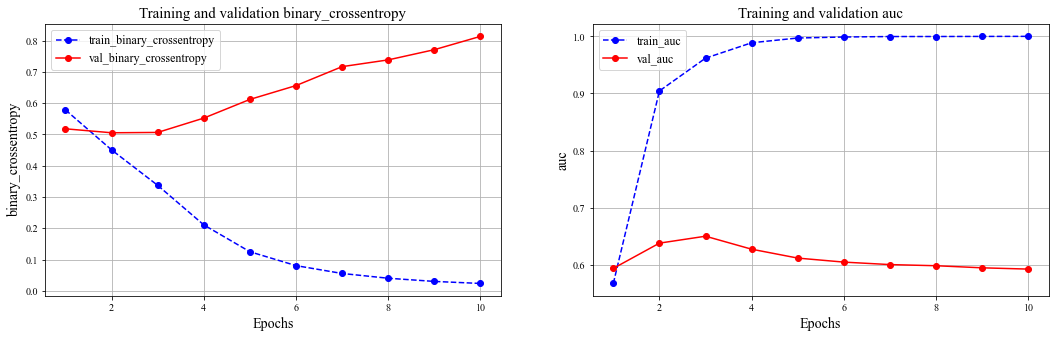

In [27]:
# 观察损失和准确率的变化
dfhistory = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
plot_metric(dfhistory, "binary_crossentropy", ax1)
plot_metric(dfhistory, "auc", ax2)

## DeepFM的优点

优点： 
1) 它不需要任何预训练;  
2) 它学习高阶和低阶特征交互;   
3) 它介绍了一种特征嵌入的共享策略，以避免进行特征工程.  

## 参考

[deepFM in pytorch](https://blog.csdn.net/w55100/article/details/90295932#t5)  
[DeepFM算法](https://www.jianshu.com/p/d199312eda64)  
[DeepFM算法解析](https://blog.csdn.net/zhongqiqianga/article/details/103714616)  
[DeepFM论文详解](http://mp.weixin.qq.com/s?src=11&timestamp=1618726188&ver=3015&signature=4SGPT4d2qjcYcSAmPq-l66VeTG1HFnhoLRzHMmFUwX9QE67aheKVc265FPqIZ9fdoATd21afjDgGROUwvdOiqjwDYJj427aS*KKrAa9JMNoAQCnMlXbdmqQHVz*MstzI&new=1)  